In [50]:
#keeps the information about the experiment

import numpy as np

class data:
    
    def __init__(self):
                
        self.const = 10000 #magnetic constant
    
        self.flux_real = 723 #will try to estimate it
        self.flux_min = 0 #min possible flux
        self.flux_max = 1000 #max possible flux
        self.flux_step = 0.01
         
        self.t_min = (np.pi / 2) / (self.const * (self.flux_max + self.flux_min) / 2) #min time delay
        self.t_max = (np.pi / 2) / (self.const * (self.flux_max + self.flux_min) / 2) * 1024 #max time delay
    
        self.n = round((self.flux_max - self.flux_min) / self.flux_step) + 1 #amount of dots
    
        self.initial = [] #keeps the uniform distribution
        self.present = [] #keeps the present distribution
        self.interval = [] #keeps fluxes in range of flux_min to flux_max
    
        self.delta_flux = [] #keeps the flux errors
        self.delta_delay = [] #keeps the total delay time
    
        self.repeat = 50
        
        self.t = self.t_min #current time delay 
        
        for i in range(self.n):
            self.initial.append(1 / self.n)
            self.present.append(1 / self.n)
            self.interval.append(self.flux_min + i * self.flux_step)
            
            
    def double_delay(self):
        self.t *= 2

In [43]:
#immitates the measure result

import numpy as np

np.random.seed(47)

def randbin(please, f):

    phi = please.const * f * please.t
    p_0 = (np.sin(phi / 2)) ** 2
    return np.random.choice([0,1], size=(1,1), p=[p_0, 1-p_0]).reshape(1)[0]

#returns the probability of the given state depending on the given flux 

import numpy as np

def pstate(please, x, f):
    if x == 0:
        return (np.sin(please.const * f * please.t / 2)) ** 2
    elif x == 1:
        return (np.cos(please.const * f * please.t / 2)) ** 2

In [44]:
#the bayes theorem

def bayes(please):
    
    serv_int = 0
    
    for i in range(please.repeat):
        serv_int += randbin(please, please.flux_real)
    h = round(serv_int / please.repeat)
    
    normalization = 0

    for i in range(len(please.present)):
        please.present[i] = please.present[i] * pstate(please, h, please.flux_min + i * please.flux_step)
        normalization += please.present[i]
    
    for i in range(len(please.present)):
        please.present[i] /= normalization

In [45]:
#draws the function

import matplotlib.pyplot as plt
import numpy as np

def draw_distr(data, x, array1, array2):
    
    plt.rcParams['figure.figsize'] = [10, 10]
    
    plt.plot(x, array1, 'o', color = 'b', label = 'final step')
    plt.plot(x, array2, 'o', color = 'r', label = 'initial')
    
    plt.title('distribution', fontsize=20)
    plt.minorticks_on()
    plt.grid(which='major', color='k', linewidth=1)
    plt.grid(which='minor', color='k', linestyle=':')
    
    plt.show()

def draw_scale(dflux, dtime):
    
    heiz = np.array([])
    shot = np.array([])
    
    dflux = np.array(dflux)
    dtime = np.array(dtime)
    
    for i in range(len(dtime)):
        heiz = np.append(heiz, np.log2(1 / dtime[i]))
        shot = np.append(shot, np.log2(1 / np.sqrt(dtime[i])))     
    
    for i in range(len(dtime)):
        dflux[i] = np.log2(dflux[i])
        dtime[i] = np.log2(dtime[i])
    
    plt.rcParams['figure.figsize'] = [10,10]
    
    A3 = np.vstack([dtime, np.ones(len(dtime))]).T
    m3, c3 = np.linalg.lstsq(A3, dflux, rcond=None)[0]
    plt.plot(dtime, dflux, 'o', color = 'k', markersize = 5)
    plt.plot(dtime, m3*dtime + c3, 'c', label = 'experiment')
    
    A1 = np.vstack([dtime, np.ones(len(dtime))]).T
    m1, c1 = np.linalg.lstsq(A1, heiz, rcond=None)[0]
    plt.plot(dtime, heiz, 'o', color = 'k', markersize = 5)
    plt.plot(dtime, m1*dtime + c3, 'g', label='heizenberg')
    
    A2 = np.vstack([dtime, np.ones(len(shot))]).T
    m2, c2 = np.linalg.lstsq(A2, shot, rcond=None)[0]
    plt.plot(dtime, shot, 'o', color = 'k', markersize = 5)
    plt.plot(dtime, m2*dtime + c3, 'g', label = 'shot noise')
    
    plt.title('scaling', fontsize=20)
    plt.minorticks_on()
    plt.grid(which='major', color='k', linewidth=1)
    plt.grid(which='minor', color='k', linestyle=':')
    
    print('slope:', m3,'intercept:', c3)
    
    plt.show()

In [46]:
#calculates the average 

def avg(x, y):
    
    avg = 0
    normalization = 0
    
    for i in range(len(x)):
        avg += x[i] * y[i]
        normalization += x[i]
        
    return avg / normalization #average x

In [47]:
#calculates the error

import numpy as np

def sigma(probs, fluxes):
    
    number = 1 / np.sqrt(2)
    
    pike_x = avg(probs, fluxes) 
    pike_y = 0
    
    for i in range(len(probs)):
        if probs[i] > pike_y:
            pike_y = probs[i]
    
    flux_step = fluxes[1] - fluxes[0]
    
    count = 0
    
    for i in range(len(probs)):
        if probs[i] > number * pike_y:
            count = count + 1
        
    return count * flux_step / 2

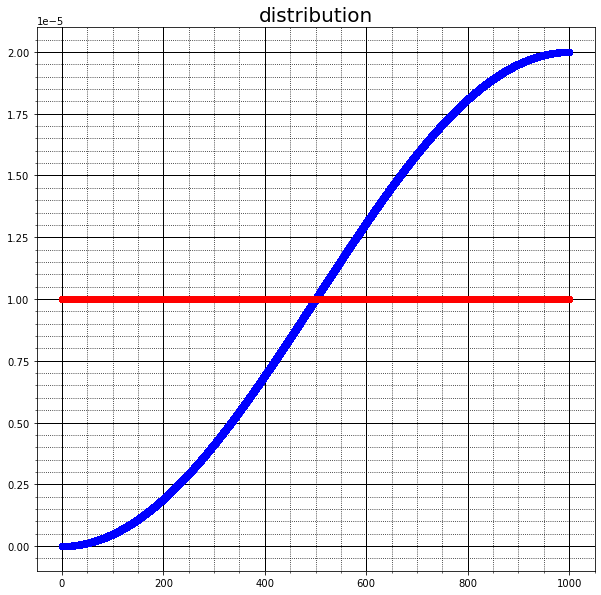

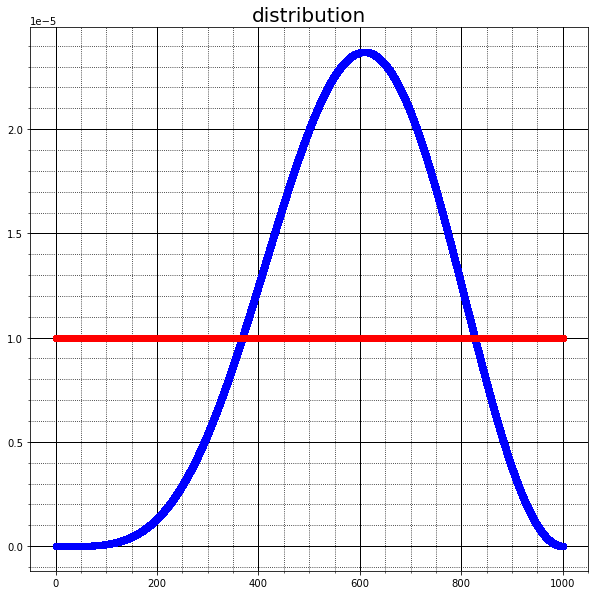

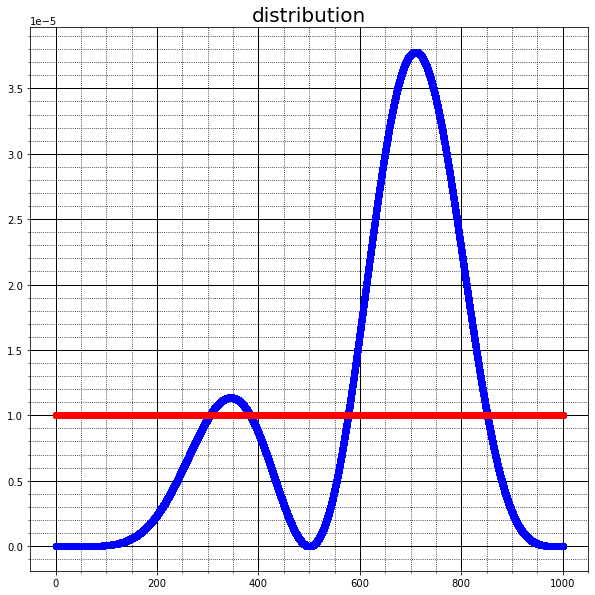

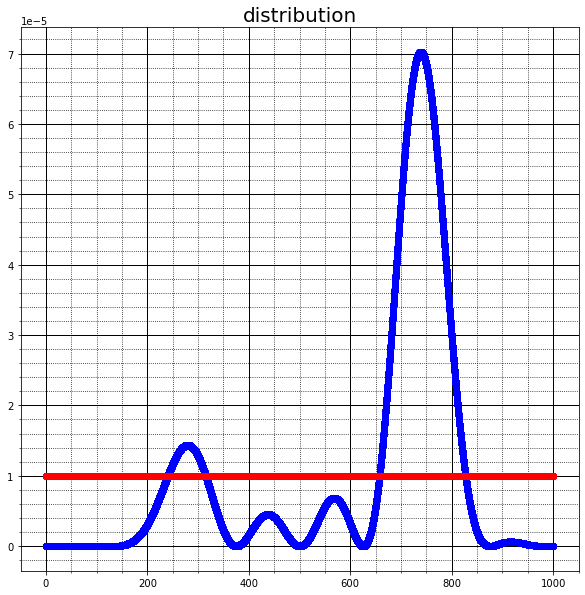

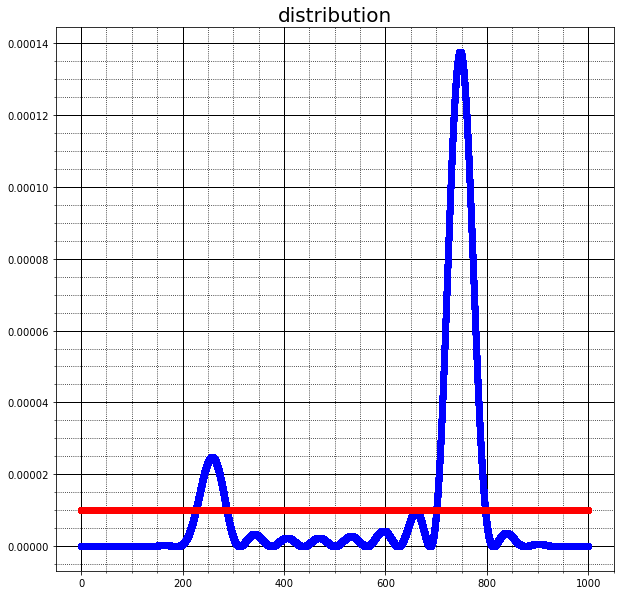

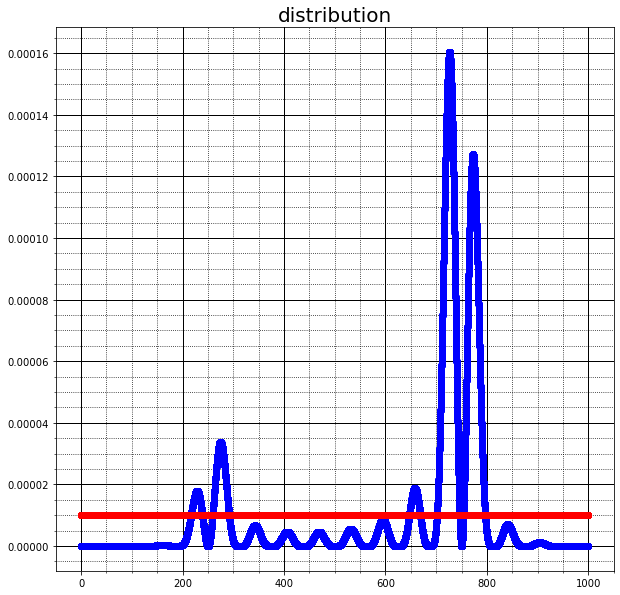

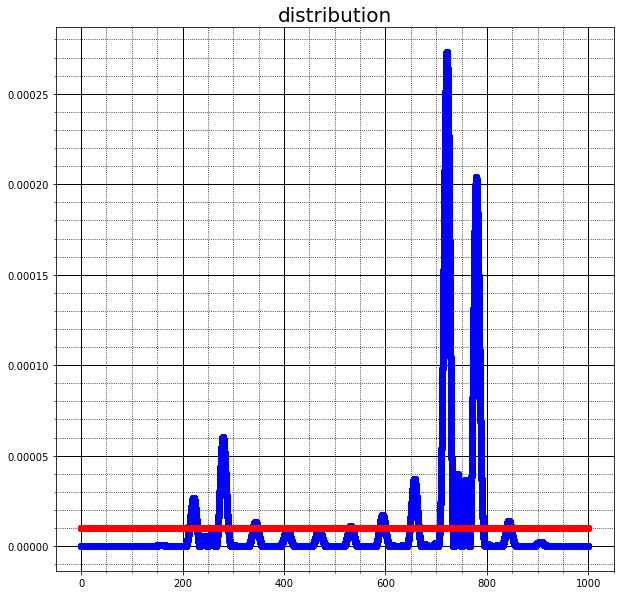

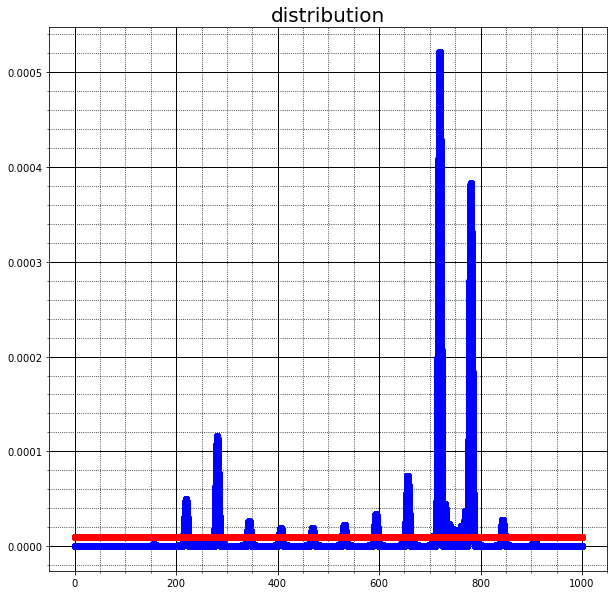

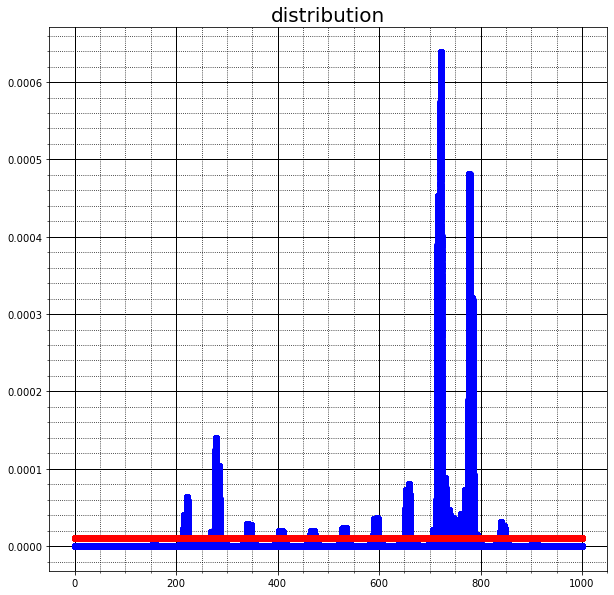

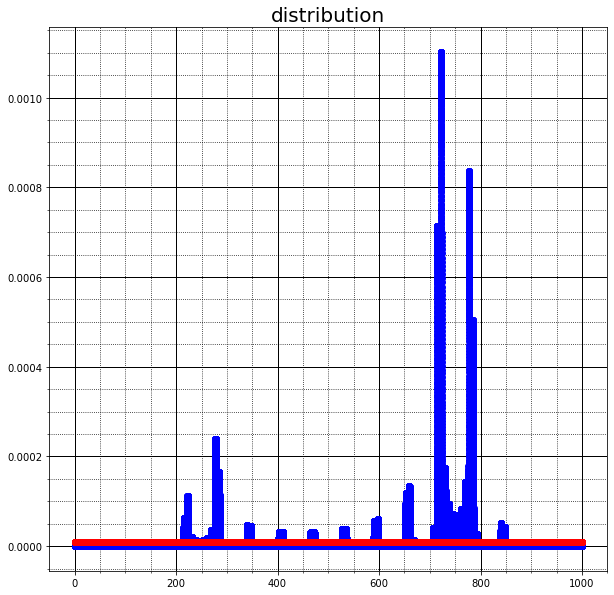

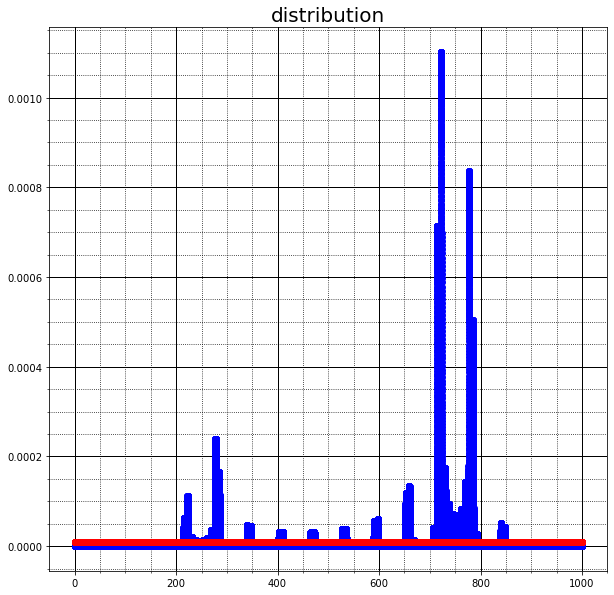

calculated flux is 657.7370957316197 +- 0.88 ( 0.1337920585155914 %)
and the real flux was 723 . mistake: 9.026681088296035 %
slope: -1.2173568722027786 intercept: -5.837712517702653


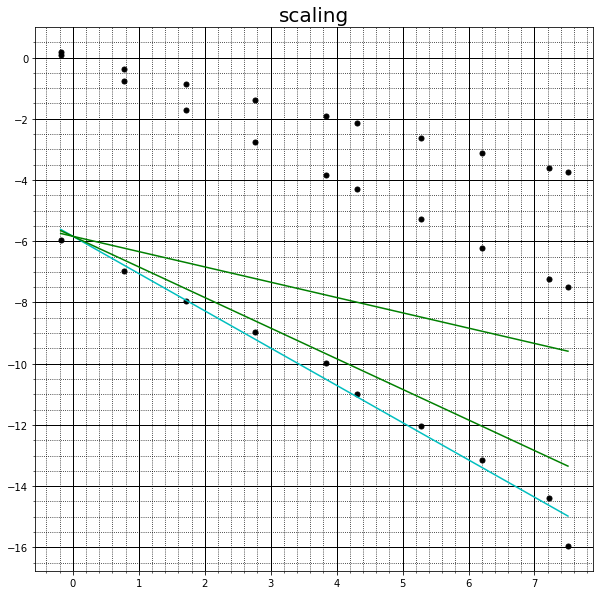

In [51]:
#main

import numpy as np

experiment = data()

for i in range(int(np.log2(experiment.t_max/ experiment.t_min))):

    bayes(experiment)
    
    err = sigma(experiment.present, experiment.interval)
        
    draw_distr(experiment, experiment.interval, experiment.present, experiment.initial)
        
    experiment.delta_flux.append(err)
    
    if i == 0:
        experiment.delta_delay.append(experiment.t * experiment.repeat)
    else:
        experiment.delta_delay.append(experiment.t * experiment.repeat + experiment.delta_delay[i-1])
    
    experiment.double_delay()

draw_distr(experiment, experiment.interval, experiment.present, experiment.initial)
    
calculated = avg(experiment.present, experiment.interval)

print('calculated flux is', calculated, '+-', err, '(', err / calculated * 100, '%)')

print('and the real flux was', experiment.flux_real, '. mistake:',
      abs(calculated - experiment.flux_real) / experiment.flux_real * 100, '%')

#draw_distr(experiment, present, initial)
    
draw_scale(experiment.delta_delay, experiment.delta_flux)

del experiment